# Using the kmsr optimization on real data

In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric
from scipy.spatial import distance as dist
import numpy as np

## Parsing a file

In [2]:
def read_data(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)  # uses spaces as delimiter by default, the first row is "x,y"
    return points

C:\Users\Mattis\AppData\Local\Temp\ipykernel_16112\3846370034.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 0], points[:, 1], marker='o', s=25, edgecolor="k", cmap="coolwarm")


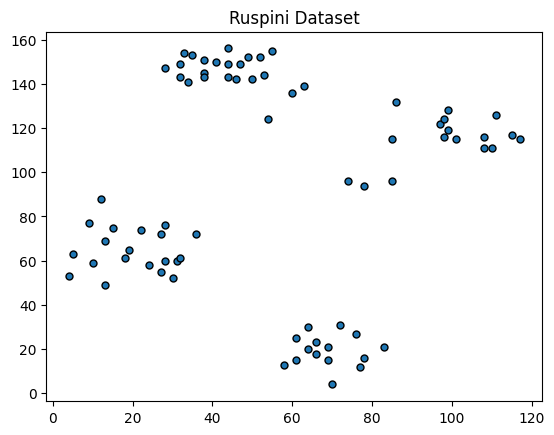

In [3]:
filename = "data_sets/ruspini.csv" # small dataset of four groups
points = read_data(filename)
k = 4

plt.title("Ruspini Dataset")
plt.scatter(points[:, 0], points[:, 1], marker='o', s=25, edgecolor="k", cmap="coolwarm")
plt.show()

## Computing the LP

In [4]:
# distance function
distances = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = distances.pairwise(points)

# model
m = gp.Model("kmsr")

# variable
y = m.addVars(len(points), len(points), vtype=GRB.BINARY, name="Y") # for dummies (me): adds a 10x10 grid of binary variables y_ij that can be either 0 or 1, which will be used to check which clusters overlap a given point

# objective:
m.setObjective(gp.quicksum([y[i, j] * radii[i][j] for i in range(len(radii)) for j in range(len(radii[i]))]),  GRB.MINIMIZE) # should be the minimization of the sum of active y_ij times their respective radii

# constraints:

# every point is covered by atleast one center/radius y_ij
for n in range(len(points)):
        m.addConstr(gp.quicksum([y[i, j] for j in range(len(radii)) for i in range (len(radii)) if radii[i][j] >= dist.euclidean(points[n], points[i])]) >= 1, "every_point_covered") 
"""for every point we enforce that the sum of all y_ij that represent a center/radius combination where the distance from the point to that center is 
    close enough to the point for the radius to cover it is atleast 1. because then, there is always a y_ij active for every point that covers it"""

# exactly k centers open in total (not per row of y, so we don't get the sum of 10 different solutions)
m.addConstr(gp.quicksum([y[i, j] for i in range (len(radii)) for j in range(len(radii[i]))]) == k, "select_k_Centers")

# do the thing
m.optimize()

Set parameter Username
Set parameter LicenseID to value 2629995
Academic license - for non-commercial use only - expires 2026-03-01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 76 rows, 5625 columns and 219458 nonzeros
Model fingerprint: 0xc8539e87
Variable types: 0 continuous, 5625 integer (5625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 335.3747313
Presolve added 514 rows and 0 columns
Presolve removed 0 rows and 1599 columns
Presolve time: 0.12s
Presolved: 590 rows, 4026 columns, 79346 nonzeros
Found heuristic solution: objective 87.6656326
Variable types: 0 continuous, 4026 integer (3396 binary)

Root relaxa

In [5]:
final_centers = [points[i] for i in range(len(points)) for j in range(len(radii[i])) if y[i, j].x == 1]
final_radii = [radii[i][j] for i in range(len(radii)) for j in range(len(radii[i])) if y[i, j].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center {i} at point {final_centers[i]} with radius {final_radii[i]}")

Optimal centers:
Center 0 at point [ 4. 53.] with radius 0.0
Center 1 at point [78. 94.] with radius 82.00609733428362
Center 2 at point [70.  4.] with radius 0.0
Center 3 at point [58. 13.] with radius 0.0


## Visual Solution

C:\Users\Mattis\AppData\Local\Temp\ipykernel_16112\788402991.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 0], points[:, 1], marker='o', s=sizes, edgecolor="k", cmap="coolwarm")


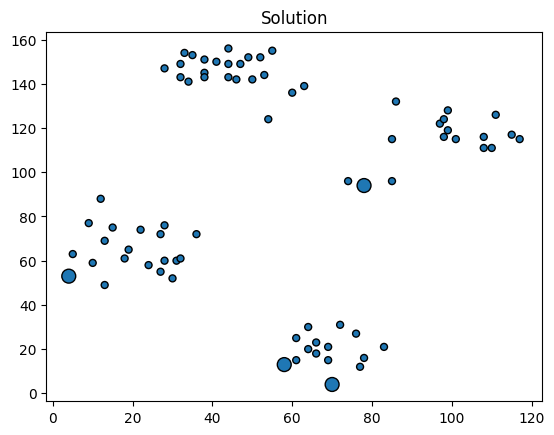

In [6]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

Clearly, the objective function leads to very peculiar solutions, as it tends to prefer enlarging existing clusters. In this case, it leads to essentially on giant cluster.